# Task
* Apply deep learning or machine learning to screen complete databases of PubChem and ChEMBL against two given proteins and find the top 1000 small molecules.
* Screen the compounds without considering the Lipinski's Rule of Five.
* Create visual representations, including a heatmap-like graph of compound database sizes and supplementary files containing compound SMILES.
* Choose the training data to predict compounds with roles in cell reprogramming.
* Provide a complete flow of the screening process and graphs, focusing on one analysis.

## Steps
1. Data Preparation:
>* Load the protein structure data.
>* Download and preprocess compound data from PubChem and ChEMBL.
>* Convert compound SMILES to molecular fingerprints.

2. Compound Screening:
>* Screen compounds from PubChem and ChEMBL using your defined criterion.
>* Select the top 1000 compounds based on your screening approach.
>* Save the top compound SMILES to a file.

3. Visualization:
>* Create a heatmap-like graph showing the total number of compounds in PubChem and ChEMBL.
>* Visualize the top 1000 screened compounds using appropriate visualization tools.

4. Supplementary Files:
>* Prepare supplementary files containing the SMILES of the top 1000 compounds.

# Setup

#### Relevant LIbraries

In [1]:
%%time
import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import AllChem
import chemprop
import warnings
import pandas as pd
import numpy as np
from Bio import PDB
from rdkit import Chem
import pubchempy as pcp
import matplotlib.cm as cm
from Bio.PDB import PDBParser
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import Image, display
from Bio.PDB import MMCIFParser, Polypeptide
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_absolute_error, mean_squared_error

CPU times: user 2.86 s, sys: 423 ms, total: 3.29 s
Wall time: 3.07 s


# Data

* <b>Protein Visual</b>

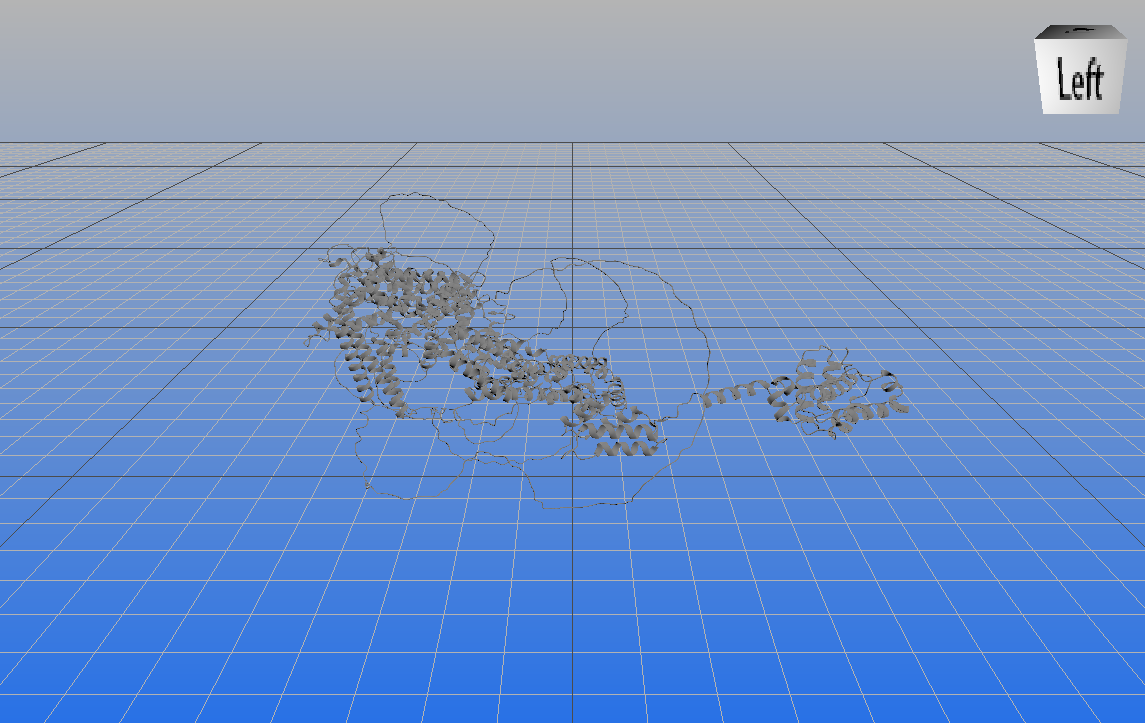

In [2]:
display(Image(filename='./data/download.png'))


## Protein Properties

In [3]:
# Path to the PDB file
pdb_file_path = "./data/thoc2.pdb"

# Load protein structure from PDB file
parser = PDBParser(QUIET=True)
structure = parser.get_structure("protein", pdb_file_path)

# Specific chain i.e chain A
chain_id = "A"
chain = structure[0][chain_id]

# Properties from the protein chain
protein_properties = {
    "ChainID": chain.id,
    "Number of Residues": len(list(chain.get_residues())),
    "Number of Atoms": len(list(chain.get_atoms())),
    "Sequence": "".join([residue.get_resname() for residue in chain.get_residues()])
}


In [4]:
# Iterate through the structure and extract relevant information
for model in structure:
    for chain in model:
        chain_id = chain.id
        seq = []
        
        for residue in chain:
            # Check if the residue is an amino acid
            if PDB.is_aa(residue):
                # Get the amino acid's one-letter code
                aa_code = PDB.Polypeptide.three_to_one(residue.get_resname())
                seq.append(aa_code)
        
        # Print relevant information
        print(f"Chain {chain_id}:")
        print()
        print("Amino Acid Sequence:", ''.join(seq))
        print()
        print("Number of Amino Acids:", len(seq))

Chain A:

Amino Acid Sequence: MAAAAVVVPAEWIKNWEKSGRGEFLHLCRILSENKSHDSSTYRDFQQALYELSYHVIKGNLKHEQASNVLSDISEFREDMPSILADVFCILDIETNCLEEKSKRDYFTQLVLACLYLVSDTVLKERLDPETLESLGLIKQSQQFNQKSVKIKTKLFYKQQKFNLLREENEGYAKLIAELGQDLSGSITSDLILENIKSLIGCFNLDPNRVLDVILEVFECRPEHDDFFISLLESYMSMCEPQTLCHILGFKFKFYQEPNGETPSSLYRVAAVLLQFNLIDLDDLYVHLLPADNCIMDEHKREIAEAKQIVRKLTMVVLSSEKMDEREKEKEKEEEKVEKPPDNQKLGLLEALLKIGDWQHAQNIMDQMPPYYAASHKLIALAICKLIHITIEPLYRRVGVPKGAKGSPVNALQNKRAPKQAESFEDLRRDVFNMFCYLGPHLSHDPILFAKVVRIGKSFMKEFQSDGSKQEDKEKTEVILSCLLSITDQVLLPSLSLMDCNACMSEELWGMFKTFPYQHRYRLYGQWKNETYNSHPLLVKVKAQTIDRAKYIMKRLTKENVKPSGRQIGKLSHSNPTILFDYILSQIQKYDNLITPVVDSLKYLTSLNYDVLAYCIIEALANPEKERMKHDDTTISSWLQSLASFCGAVFRKYPIDLAGLLQYVANQLKAGKSFDLLILKEVVQKMAGIEITEEMTMEQLEAMTGGEQLKAEGGYFGQIRNTKKSSQRLKDALLDHDLALPLCLLMAQQRNGVIFQEGGEKHLKLVGKLYDQCHDTLVQFGGFLASNLSTEDYIKRVPSIDVLCNEFHTPHDAAFFLSRPMYAHHISSKYDELKKSEKGSKQQHKVHKYITSCEMVMAPVHEAVVSLHVSKVWDDISPQFYATFWSLTMYDLAVPHTSYEREVNKLKVQMKAIDDNQEMPPNKKKKEKERCTALQDKLLEEEKKQMEHVQRVLQRLKLEKDNWLLAKST

* <b>Amino Acid Composition</b>
>This visualization shows the distribution of amino acids in the protein sequence. Different amino acids have different properties, such as hydrophobicity, charge, and size. A high proportion of hydrophobic amino acids might suggest a protein with a membrane-spanning region, while a high proportion of charged amino acids might indicate a protein with enzymatic activity.

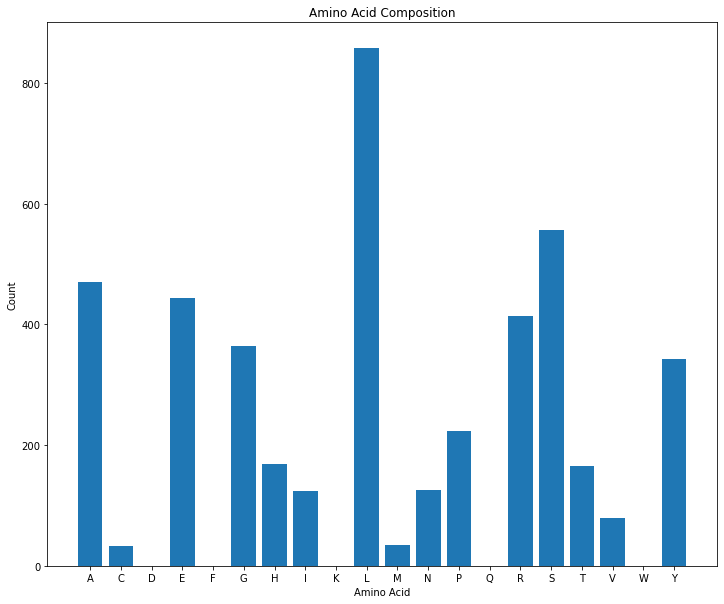

In [5]:
# Protein sequence
protein_sequence = protein_properties['Sequence']

# Count amino acids
aa_counts = {aa: protein_sequence.count(aa) for aa in "ACDEFGHIKLMNPQRSTVWY"}

# Create a bar chart
plt.figure(figsize =(12, 10))
plt.bar(aa_counts.keys(), aa_counts.values())
plt.xlabel("Amino Acid")
plt.ylabel("Count")
plt.title("Amino Acid Composition")
plt.show()


* <b>Hydrophobicity Plot</b>
>The hydrophobicity plot highlights regions of the protein that are more or less hydrophobic. Hydrophobic regions often play a role in protein-protein interactions, membrane binding, and protein folding

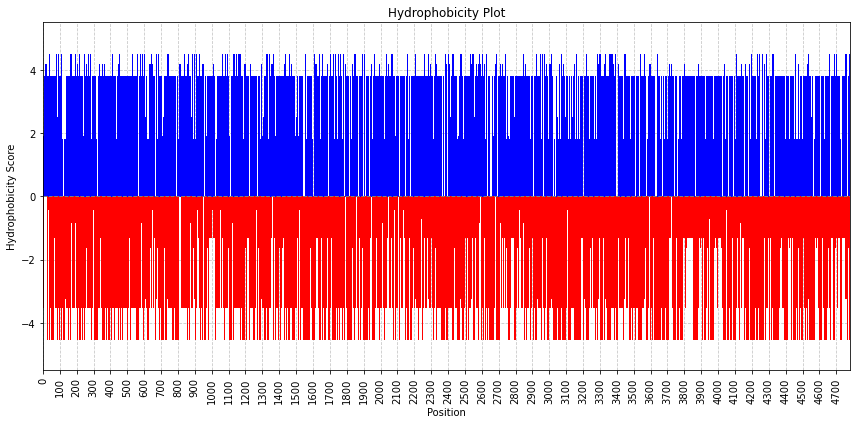

In [6]:
# Kyte-Doolittle hydrophobicity scale
hydrophobicity_scale = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5,
    'F': 2.8, 'G': -0.4, 'H': -3.2, 'I': 4.5,
    'K': -3.9, 'L': 3.8, 'M': 1.9, 'N': -3.5,
    'P': -1.6, 'Q': -3.5, 'R': -4.5, 'S': -0.8,
    'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
}

# Calculate hydrophobicity scores, assign 0 for non-standard amino acids
hydrophobicity_scores = [hydrophobicity_scale.get(aa, 0) for aa in protein_sequence]

# Define positive and negative colors
positive_color = 'blue'
negative_color = 'red'

# Plotting
plt.figure(figsize=(12, 6))
for i, score in enumerate(hydrophobicity_scores):
    color = positive_color if score > 0 else negative_color
    plt.plot([i, i], [0, score], color=color, linewidth=1)

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Position')
plt.ylabel('Hydrophobicity Score')
plt.title('Hydrophobicity Plot')
plt.xticks(range(0, len(protein_sequence), 100), rotation=90)
plt.xlim(0, len(protein_sequence))
plt.ylim(min(hydrophobicity_scale.values()) - 1, max(hydrophobicity_scale.values()) + 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


* <b>Sequence Heatmap</b>

/tmp/ipykernel_14327/3061010871.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab20')


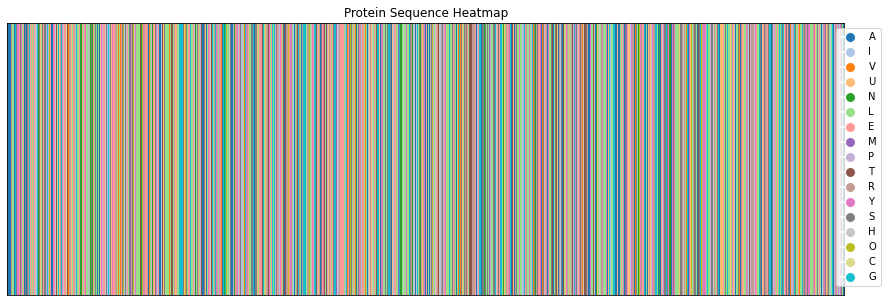

In [7]:
# Create a list of unique amino acids
unique_amino_acids = list(set(protein_sequence))

# Get a colormap from matplotlib
color_map = cm.get_cmap('tab20')

# Create a mapping of amino acids to colors
amino_acid_colors = {aa: color_map(i / len(unique_amino_acids)) for i, aa in enumerate(unique_amino_acids)}

# Create a list of colors corresponding to each amino acid
sequence_colors = [amino_acid_colors[aa] for aa in protein_sequence]

# Create a figure and axis for the heatmap
fig, ax = plt.subplots(figsize=(15, 5))

# Create a color-coded heatmap
heatmap = np.array([sequence_colors])
cax = ax.matshow(heatmap, aspect='auto')

# Remove x and y ticks
ax.set_xticks([])
ax.set_yticks([])

# Create a color legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=amino_acid_colors[aa], markersize=10) for aa in unique_amino_acids]
ax.legend(legend_handles, unique_amino_acids, loc='upper right', bbox_to_anchor=(1.05, 1))

# Set title
ax.set_title('Protein Sequence Heatmap')

plt.show()


# Compound Screening
>Compound screening aimed at identifying potential chemical compounds that can interact with our specific protein of interest. WE used the sequence to do the screeing at PDB.
>
[Results]('https://www.rcsb.org/search?request=%7B%22query%22%3A%7B%22type%22%3A%22group%22%2C%22nodes%22%3A%5B%7B%22type%22%3A%22group%22%2C%22nodes%22%3A%5B%7B%22type%22%3A%22group%22%2C%22nodes%22%3A%5B%7B%22type%22%3A%22terminal%22%2C%22service%22%3A%22text%22%2C%22parameters%22%3A%7B%22attribute%22%3A%22rcsb_entry_info.structure_determination_methodology%22%2C%22operator%22%3A%22exact_match%22%2C%22value%22%3A%22experimental%22%7D%7D%5D%2C%22logical_operator%22%3A%22and%22%7D%5D%2C%22logical_operator%22%3A%22and%22%2C%22label%22%3A%22text%22%7D%2C%7B%22type%22%3A%22terminal%22%2C%22service%22%3A%22sequence%22%2C%22parameters%22%3A%7B%22evalue_cutoff%22%3A0.1%2C%22identity_cutoff%22%3A0%2C%22sequence_type%22%3A%22protein%22%2C%22value%22%3A%22MAAAAVVVPAEWIKNWEKSGRGEFLHLCRILSENKSHDSSTYRDFQQALYELSYHVIKGNLKHEQASNVLSDISEFREDMPSILADVFCILDIETNCLEEKSKRDYFTQLVLACLYLVSDTVLKERLDPETLESLGLIKQSQQFNQKSVKIKTKLFYKQQKFNLLREENEGYAKLIAELGQDLSGSITSDLILENIKSLIGCFNLDPNRVLDVILEVFECRPEHDDFFISLLESYMSMCEPQTLCHILGFKFKFYQEPNGETPSSLYRVAAVLLQFNLIDLDDLYVHLLPADNCIMDEHKREIAEAKQIVRKLTMVVLSSEKMDEREKEKEKEEEKVEKPPDNQKLGLLEALLKIGDWQHAQNIMDQMPPYYAASHKLIALAICKLIHITIEPLYRRVGVPKGAKGSPVNALQNKRAPKQAESFEDLRRDVFNMFCYLGPHLSHDPILFAKVVRIGKSFMKEFQSDGSKQEDKEKTEVILSCLLSITDQVLLPSLSLMDCNACMSEELWGMFKTFPYQHRYRLYGQWKNETYNSHPLLVKVKAQTIDRAKYIMKRLTKENVKPSGRQIGKLSHSNPTILFDYILSQIQKYDNLITPVVDSLKYLTSLNYDVLAYCIIEALANPEKERMKHDDTTISSWLQSLASFCGAVFRKYPIDLAGLLQYVANQLKAGKSFDLLILKEVVQKMAGIEITEEMTMEQLEAMTGGEQLKAEGGYFGQIRNTKKSSQRLKDALLDHDLALPLCLLMAQQRNGVIFQEGGEKHLKLVGKLYDQCHDTLVQFGGFLASNLSTEDYIKRVPSIDVLCNEFHTPHDAAFFLSRPMYAHHISSKYDELKKSEKGSKQQHKVHKYITSCEMVMAPVHEAVVSLHVSKVWDDISPQFYATFWSLTMYDLAVPHTSYEREVNKLKVQMKAIDDNQEMPPNKKKKEKERCTALQDKLLEEEKKQMEHVQRVLQRLKLEKDNWLLAKSTKNETITKFLQLCIFPRCIFSAIDAVYCARFVELVHQQKTPNFSTLLCYDRVFSDIIYTVASCTENEASRYGRFLCCMLETVTRWHSDRATYEKECGNYPGFLTILRATGFDGGNKADQLDYENFRHVVHKWHYKLTKASVHCLETGEYTHIRNILIVLTKILPWYPKVLNLGQALERRVHKICQEEKEKRPDLYALAMGYSGQLKSRKSYMIPENEFHHKDPPPRNAVASVQNGPGGGPSSSSIGSASKSDESSTEETDKSRERSQCGVKAVNKASSTTPKGNSSNGNSGSNSNKAVKENDKEKGKEKEKEKKEKTPATTPEARVLGKDGKEKPKEERPNKDEKARETKERTPKSDKEKEKFKKEEKAKDEKFKTTVPNAESKSTQEREREKEPSRERDIAKEMKSKENVKGGEKTPVSGSLKSPVPRSDIPEPEREQKRRKIDTHPSPSHSSTVKDSLIELKESSAKLYINHTPPPLSKSKEREMDKKDLDKSRERSREREKKDEKDRKERKRDHSNNDREVPPDLTKRRKEENGTMGVSKHKSESPCESPYPNEKDKEKNKSKSSGKEKGSDSFKSEKMDKISSGGKKESRHDKEKIEKKEKRDSSGGKEEKKHHKSSDKHR%22%7D%7D%5D%2C%22logical_operator%22%3A%22and%22%7D%2C%22return_type%22%3A%22entry%22%2C%22request_options%22%3A%7B%22paginate%22%3A%7B%22start%22%3A0%2C%22rows%22%3A25%7D%2C%22results_content_type%22%3A%5B%22experimental%22%5D%2C%22sort%22%3A%5B%7B%22sort_by%22%3A%22score%22%2C%22direction%22%3A%22desc%22%7D%5D%2C%22scoring_strategy%22%3A%22combined%22%7D%2C%22request_info%22%3A%7B%22query_id%22%3A%227ef0e7afb0f4d710c5f0e11761ec3392%22%7D%7D')

### SMILES and Molecular Structures:

* **SMILES** (Simplified Molecular Input Line Entry System) is a notation that represents a chemical compound's structure in a concise and standardized manner.
* For each identified compound, retrieve its SMILES representation and 3D molecular structure

In [8]:
# def get_compound_info(cid):
#     try:
#         compound = pcp.Compound.from_cid(cid)
#         return compound
#     except pcp.NotFoundError:
#         print(f"Compound with CID {cid} not found.")
#         return None

# def retrieve_smiles_and_3d_structure(cid):
#     compound = get_compound_info(cid)
#     if compound:
#         smiles = compound.canonical_smiles
#         mol = Chem.MolFromSmiles(smiles)
#         if mol:
#             mol = Chem.AddHs(mol)
#             AllChem.EmbedMolecule(mol, AllChem.ETKDG())
#             return smiles, mol
#     return None, None

# def main():
#     cid_file_path = './data/pccompound_result.txt'
    
#     with open(cid_file_path, 'r') as cid_file:
#         cids = [line.strip() for line in cid_file]

#     data = []
#     for cid in cids:
#         smiles, _ = retrieve_smiles_and_3d_structure(cid)
#         if smiles:
#             data.append({'CID': cid, 'SMILES': smiles})

#     df = pd.DataFrame(data)
#     df.to_csv('cids_with_smiles.csv', index=False)

# if __name__ == "__main__":
#     main()


* <b> Preview screened compounds

In [21]:
from chembl_webresource_client.new_client import new_client

available_resources = [resource for resource in dir(new_client) if not resource.startswith('_')]
print(available_resources)

['activity', 'activity_supplementary_data_by_activity', 'assay', 'assay_class', 'atc_class', 'binding_site', 'biotherapeutic', 'cell_line', 'chembl_id_lookup', 'compound_record', 'compound_structural_alert', 'description', 'document', 'document_similarity', 'drug', 'drug_indication', 'drug_warning', 'go_slim', 'image', 'mechanism', 'metabolism', 'molecule', 'molecule_form', 'official', 'organism', 'protein_classification', 'similarity', 'source', 'substructure', 'target', 'target_component', 'target_relation', 'tissue', 'xref_source']


# Data Preprocessing:
* >Convert SMILES strings to molecular fingerprints or other numerical representations suitable for machine learning.
* >Gather additional information about the compounds (e.g., molecular weight, properties).

<b>Convert SMILES to Molecular Fingerprints

In [12]:
# from rdkit import Chem
# from rdkit.Chem import AllChem
# from rdkit.Chem import DataStructs

# def generate_molecular_fingerprint(smiles):
#     mol = Chem.MolFromSmiles(smiles)
#     if mol:
#         mol = Chem.AddHs(mol)
#         fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
#         return fingerprint
#     return None

# def main():
#     df = pd.read_csv('./data/cids_with_smiles.csv') 

#     fingerprints = []
#     for smiles in df['SMILES']:
#         fingerprint = generate_molecular_fingerprint(smiles)
#         if fingerprint:
#             fingerprints.append(fingerprint)

#     df['Fingerprint'] = fingerprints
#     df.to_csv('preprocessed_data.csv', index=False)

# if __name__ == "__main__":
#     main()

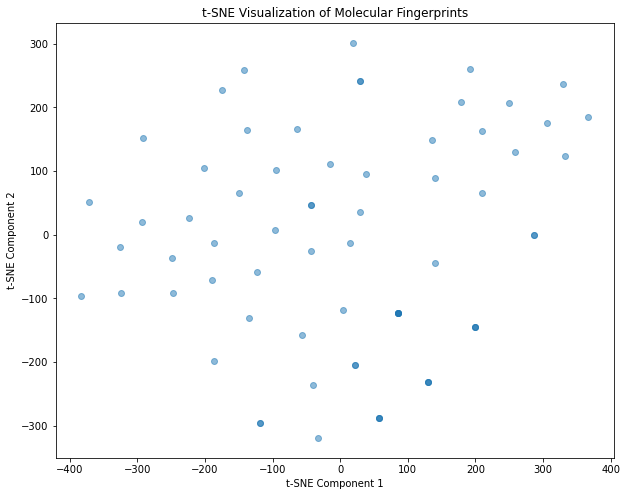

In [13]:
from sklearn.manifold import TSNE
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt

def generate_molecular_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mol = Chem.AddHs(mol)
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return fingerprint
    return None

def main():
    df = pd.read_csv('./data/preprocessed_data.csv') 

    fingerprints = np.array([generate_molecular_fingerprint(smiles) for smiles in df['SMILES']])
    
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(fingerprints)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
    plt.title('t-SNE Visualization of Molecular Fingerprints')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

if __name__ == "__main__":
    main()


<b>Gather Additional Compound Information

In [14]:
# def get_additional_info(cid):
#     try:
#         compound = pcp.Compound.from_cid(cid)
#         props = {
#             'MolecularWeight': compound.molecular_weight,
#             'LogSolubility': compound.xlogp
#         }
#         return props
#     except pcp.NotFoundError:
#         print(f"Compound with CID {cid} not found.")
#         return {}

# def main():
#     df = pd.read_csv('./data/preprocessed_data.csv') 

#     additional_info = []
#     for cid in df['CID']:
#         info = get_additional_info(cid)
#         additional_info.append(info)

#     info_df = pd.DataFrame(additional_info)
#     df = pd.concat([df, info_df], axis=1)
#     df.to_csv('final_preprocessed_data.csv', index=False)

# if __name__ == "__main__":
#     main()


In [15]:
compounds_df = pd.read_csv('./data/final_preprocessed_data.csv')


In [16]:
# regression_df = compounds_df.drop(['Fingerprint','MolecularWeight', 'CID'], axis=1)
regression_df = pd.read_csv('./data/regression_data.csv')
regression_df.head(7)

,SMILES,LogSolubility
0,CCC1=CC=C(C=C1)C2=NN(N=N2)CCNC(=O)CNCC3=CC=CC=...,3.6
1,C1=CC=C(C(=C1)CCNC(=O)CN2N=C(N=N2)C3=CC=CC=C3Cl)F,3.9
2,CC(C)CNC(=O)CN1N=C(N=N1)C2=CC=CC=C2Cl,3.2
3,C1=CC=C(C(=C1)C2=NN(N=N2)CC(=O)NCCC3=CC=C(C=C3...,3.9
4,C1=CC=C(C=C1)CNC(=O)CN2N=C(N=N2)C3=CC=CC=C3Cl,3.4
5,CC(C)C1=CC=C(C=C1)C2=NN(N=N2)CC(C)(C)C(=O)NCCC...,5.6
6,C1CCC(CC1)CNC(=O)CN2N=C(N=N2)C3=CC=C(C=C3)Cl,4.2


In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from chemprop.data import get_smiles
from chemprop.features import get_features_generator

# Machine Learning

In [18]:
from chemprop.data import MoleculeDataset
from chemprop.train import train, evaluate
from sklearn.metrics import mean_squared_error
from rdkit.DataStructs import ConvertToNumpyArray
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [26]:
data = compounds_df.copy(deep=True)
# Select features (Fingerprint) and target (LogSolubility)
X = data[["MolecularWeight"]]
y = data["LogSolubility"]


## Modeling

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.15627509823228272


In [23]:
chemprop_data = compounds_df.drop(['CID', 'Fingerprint'], axis=1)
# chemprop_data.to_csv('modeling_data.csv', index=False)
chemprop_data.head(7)

,SMILES,MolecularWeight,LogSolubility
0,CCC1=CC=C(C=C1)C2=NN(N=N2)CCNC(=O)CNCC3=CC=CC=...,398.90,3.6
1,C1=CC=C(C(=C1)CCNC(=O)CN2N=C(N=N2)C3=CC=CC=C3Cl)F,359.80,3.9
2,CC(C)CNC(=O)CN1N=C(N=N1)C2=CC=CC=C2Cl,293.75,3.2
3,C1=CC=C(C(=C1)C2=NN(N=N2)CC(=O)NCCC3=CC=C(C=C3...,359.80,3.9
4,C1=CC=C(C=C1)CNC(=O)CN2N=C(N=N2)C3=CC=CC=C3Cl,327.77,3.4
5,CC(C)C1=CC=C(C=C1)C2=NN(N=N2)CC(C)(C)C(=O)NCCC...,426.00,5.6
6,C1CCC(CC1)CNC(=O)CN2N=C(N=N2)C3=CC=C(C=C3)Cl,333.81,4.2


In [24]:
import chemprop

arguments = [
    '--data_path', 'data/modeling_data.csv',
    '--dataset_type', 'regression',
    '--save_dir', 'modeling_data_checkpoints'
]

args = chemprop.args.TrainArgs().parse_args(arguments)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)


Command line
python /home/rs/miniconda3/lib/python3.11/site-packages/ipykernel_launcher.py -f /home/rs/.local/share/jupyter/runtime/kernel-ef20a39d-c6d4-44f3-ae45-7426ac8a4375.json
Args
{'activation': 'ReLU',
 'adding_bond_types': True,
 'adding_h': False,
 'aggregation': 'mean',
 'aggregation_norm': 100,
 'atom_constraints': [],
 'atom_descriptor_scaling': True,
 'atom_descriptors': None,
 'atom_descriptors_path': None,
 'atom_descriptors_size': 0,
 'atom_features_size': 0,
 'atom_messages': False,
 'atom_targets': [],
 'batch_size': 50,
 'bias': False,
 'bias_solvent': False,
 'bond_constraints': [],
 'bond_descriptor_scaling': True,
 'bond_descriptors': None,
 'bond_descriptors_path': None,
 'bond_descriptors_size': 0,
 'bond_features_size': 0,
 'bond_targets': [],
 'cache_cutoff': 10000,
 'checkpoint_dir': None,
 'checkpoint_frzn': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'class_balance': False,
 'config_path': None,
 'constraints_path': None,
 'crossval_index_di

/home/rs/miniconda3/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


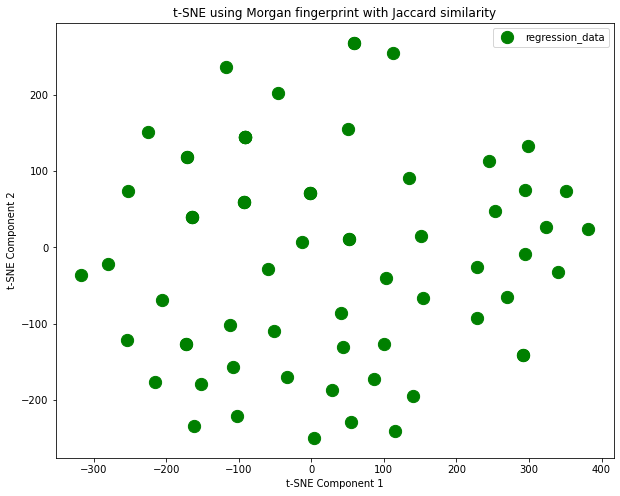

In [25]:
class Args:
    smiles_paths = ['./data/regression_data.csv']
    smiles_column = 'SMILES' 
    colors = ['g']
    sizes = [1] 
    scale = 1 
    plot_molecules = False  
    max_per_dataset = 10000 
    save_path = 'tsne_plot.png'
    cluster = False 

def compare_datasets_tsne(args):
    # Load the smiles datasets
    smiles, slices, labels = [], [], []
    for smiles_path, color, size in zip(args.smiles_paths, args.colors, args.sizes):
        new_smiles = get_smiles(path=smiles_path, smiles_columns=args.smiles_column, flatten=True)
        if len(new_smiles) > args.max_per_dataset:
            new_smiles = np.random.choice(new_smiles, size=args.max_per_dataset, replace=False).tolist()
        slices.append(slice(len(smiles), len(smiles) + len(new_smiles)))
        labels.append(os.path.basename(smiles_path).replace('.csv', ''))
        smiles += new_smiles
    
    # Compute Morgan fingerprints
    morgan_generator = get_features_generator('morgan')
    morgans = np.array([morgan_generator(smile) for smile in smiles])
    
    # Run t-SNE
    tsne = TSNE(n_components=2, init='pca', random_state=0, metric='jaccard')
    X = tsne.fit_transform(morgans)
    
    # Plot t-SNE
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1], s=150 * np.mean(args.sizes), c=args.colors)
    plt.title('t-SNE using Morgan fingerprint with Jaccard similarity')
    plt.legend(labels)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

if __name__ == '__main__':
    args = Args()
    compare_datasets_tsne(args)
